<a href="https://colab.research.google.com/github/eohta/udemy-numpyro-basic/blob/main/03_trips/02_fit_zero_inflated_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Package

In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [3]:
plt.rcParams['font.size'] = 12

## Load & Check Data

In [4]:
y = np.array([
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0])

In [5]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0
 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 2 2 0 0 0 1 0 0 1 0 3 1 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 3 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0]


## Define Model & Inference

In [6]:
def model(y=None, num_data=0):
    
    psi = numpyro.sample('psi', dist.Uniform(low=0.0, high=1.0))
    lam = numpyro.sample('mu', dist.HalfNormal(10))
    
    with numpyro.plate('data', num_data):
    
        numpyro.sample('obs', dist.ZeroInflatedPoisson(psi, rate=lam), obs=y)

In [7]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), y=y, num_data=len(y))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

## Check MCMC-samples

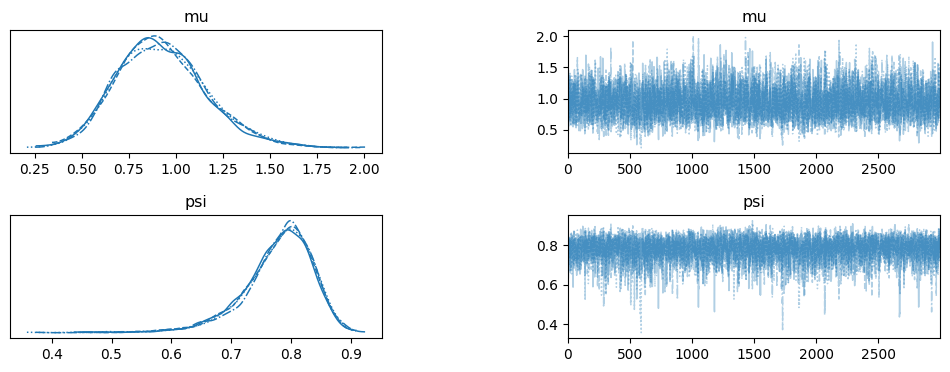

In [8]:
az.plot_trace(idata);
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

In [9]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.927,0.240,0.479,1.375,0.004,0.003,3693.0,3720.0,1.0
psi,0.778,0.059,0.669,0.877,0.001,0.001,3776.0,4046.0,1.0


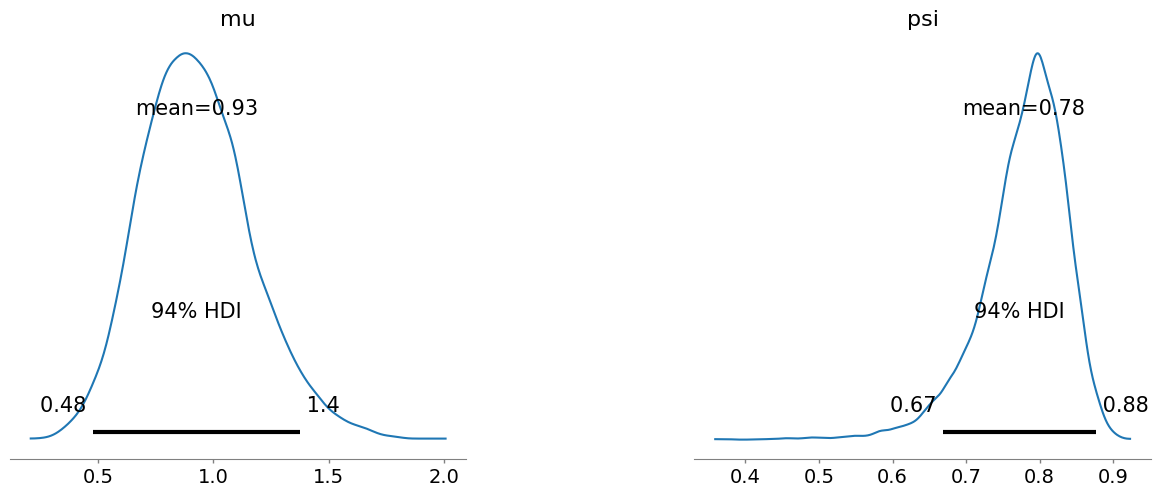

In [10]:
az.plot_posterior(idata)
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

## Posterior Predictive Check

In [11]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)

ppc_samples = predictive(jax.random.PRNGKey(1), num_data=len(y))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

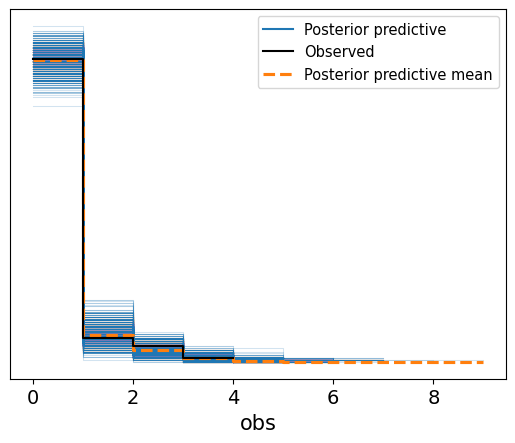

In [12]:
az.plot_ppc(idata_ppc, num_pp_samples=1000);

## Information Criteria

In [13]:
az.waic(idata, scale='deviance')

Computed from 12000 posterior samples and 200 observations log-likelihood matrix.

              Estimate       SE
deviance_waic   201.04    27.97
p_waic            1.72        -

In [14]:
az.loo(idata, scale='deviance')

Computed from 12000 posterior samples and 200 observations log-likelihood matrix.

             Estimate       SE
deviance_loo   201.05    27.97
p_loo            1.73        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      200  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Compare Models

In [15]:
idata_poisson = az.from_netcdf('idata.nc')

In [16]:
dict_idata = {'Poisson':idata_poisson, 'Zero Inflated Poisson':idata}

In [17]:
df_waic = az.compare(dict_idata, ic='waic', scale='deviance')
df_waic

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Zero Inflated Poisson,0,201.042409,1.723783,0.00000,1.000000e+00,27.971549,0.000000,False,deviance
Poisson,1,224.407599,1.539295,23.36519,3.961276e-13,31.669964,9.956024,False,deviance


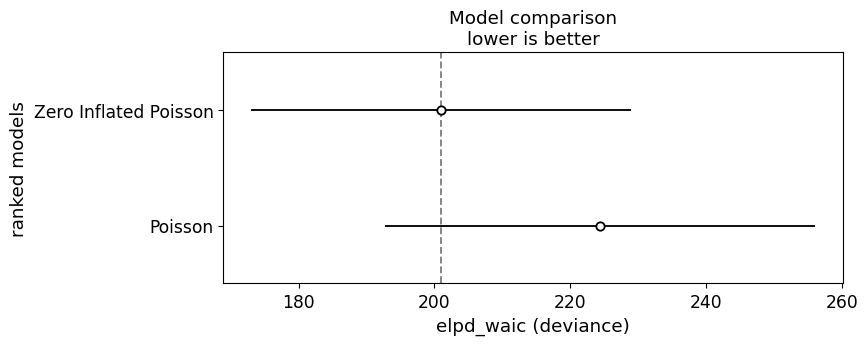

In [18]:
az.plot_compare(df_waic, figsize=(8, 3));

In [19]:
df_loo = az.compare(dict_idata, ic='loo', scale='deviance')
df_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Zero Inflated Poisson,0,201.054667,1.729912,0.000000,1.000000e+00,27.974725,0.000000,False,deviance
Poisson,1,224.409979,1.540485,23.355312,2.238210e-13,31.670636,9.952629,False,deviance


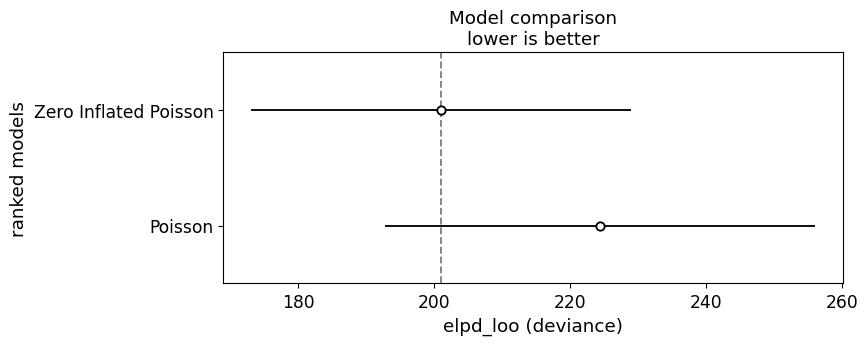

In [20]:
az.plot_compare(df_loo, figsize=(8, 3));